In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import random

In [2]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)



set_seed()
project_dir = os.path.dirname(os.path.dirname(os.getcwd()))

In [3]:
model_mn2 = MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000
)

model_mn2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [4]:
layer_name = 'block_15_add'
feature_extractor = Model(inputs=model_mn2.input, outputs=model_mn2.get_layer(layer_name).output)
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [5]:
diseases_names = []
dataset_path = os.path.join(project_dir, 'datasets', 'encoded', 'PlantDoc')

for diseases in os.listdir(os.path.join(dataset_path, 'train')):
    diseases_names += [diseases.split('.npy')[0]]

diseases_names.sort()
plant_name_to_id = {plant: i for i, plant in enumerate(diseases_names)}

In [6]:
instances = {}
labels = {}

for set_kind in ["test", "train", "val"]:
    X_per_class = []
    y_per_class = []

    for i, file in enumerate(os.listdir(os.path.join(dataset_path, set_kind))):
        print(f"\r[{i}] {set_kind}/{file}", end='')
        plants_encoded = np.load(os.path.join(dataset_path, set_kind, file))
        plant_name = file.split('.npy')[0]

        X_per_class += [plants_encoded.reshape([plants_encoded.shape[0], 49, 160])]
        y_per_class += [plant_name_to_id[plant_name] for _ in range(plants_encoded.shape[0])]

    instances[set_kind] = np.concatenate(X_per_class)
    labels[set_kind] = np.array(y_per_class)

[26] val/Tomato Septoria leaf spot.npyyyy

In [7]:
n_classes = len(diseases_names)

X_train = instances['train']
y_train = np.eye(n_classes)[labels['train']]


X_valid = instances['val']
y_valid = np.eye(n_classes)[labels['val']]

X_test = instances['test']
y_test = np.eye(n_classes)[labels['test']]

In [8]:
print(X_train[0].shape)
print(X_train[..., 0].shape)

(49, 160)
(28983, 49)


In [9]:
from sklearn.decomposition import PCA
print(X_train[..., 0].shape)


(28983, 49)


In [10]:
pca_per_filter = [
    PCA(n_components=5).fit(X_train[..., i])
    for i in range(X_train.shape[-1])
]

In [11]:
all_means = np.array([filter.mean_ for filter in pca_per_filter])
all_means = all_means.T.reshape([1, 49, 160])

all_components = np.array([filter.components_ for filter in pca_per_filter])
all_components = np.transpose(all_components, [2, 1, 0])

filterwise_dot = np.einsum('ij...,jk...->...ik', X_train - all_means, all_components)
filterwise_dot = np.transpose(filterwise_dot, axes=[1, 2, 0])

X_train_pca = filterwise_dot

all_means = np.array([filter.mean_ for filter in pca_per_filter])
all_means = all_means.T.reshape([1, 49, 160])

all_components = np.array([filter.components_ for filter in pca_per_filter])
all_components = np.transpose(all_components, [2, 1, 0])

filterwise_dot = np.einsum('ij...,jk...->...ik', X_valid - all_means, all_components)
# equivalent to einsum tf.stack([A[..., i] @ B[..., i] for i in tf.range(160)], axis=-1)
filterwise_dot = np.transpose(filterwise_dot, axes=[1, 2, 0])

X_valid_pca = filterwise_dot

In [12]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[5, 160]),
    keras.layers.BatchNormalization(),
    keras.layers.SeparableConv1D(filters=320, depth_multiplier=3, kernel_size=5),
    keras.layers.ELU(),
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.15),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(480, kernel_initializer="lecun_normal", use_bias=False),
    keras.layers.ELU(),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(27, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5, 160)           640       
 ormalization)                                                   
                                                                 
 separable_conv1d (Separable  (None, 1, 320)           156320    
 Conv1D)                                                         
                                                                 
 elu (ELU)                   (None, 1, 320)            0         
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 320)              1

In [13]:
idx = np.arange(X_train_pca.shape[0])
np.random.shuffle(idx)

X_train_pca_shuffled = X_train_pca[idx]
y_train_shuffled = y_train[idx]

In [14]:
filepath = os.path.join(project_dir, 'models', 'model_pca_based_sepconv_plantdoc')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

history = model.fit(
    X_train_pca_shuffled, y_train_shuffled,
    epochs=10,
    validation_data=(X_valid_pca, y_valid),
    callbacks=[lr_scheduler, checkpoint]
)

Epoch 1/10
906/906 [==============================] - ETA: 0s - loss: 1.3646 - accuracy: 0.5766   

INFO:tensorflow:Assets written to: C:\Users\ASROCK\PycharmProjects\plant-diseases-identification\models\model_pca_based_sepconv_plantdoc\assets


In [15]:
class PCATransformer(keras.layers.Layer):
    def __init__(self, means, components, **kwargs):
        super().__init__(**kwargs)
        self.all_means = tf.reshape(tf.transpose(means), [1, 49, 160])
        self.all_components = tf.transpose(components, perm=[0, 2, 1])

    @tf.function
    def call(self, X):
        return tf.transpose(tf.map_fn(
            lambda inp: inp[0] @ inp[1],
            (tf.transpose(X - self.all_means, perm=[2, 0, 1]), self.all_components),
            fn_output_signature=tf.TensorSpec(shape=[None, 5])
        ), perm=[1, 2, 0])

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape((batch_input_shape[0], 5, 160))

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "mean": self.all_means.numpy(), "components": self.all_components.numpy()}



In [16]:
all_means = np.array([filter.mean_ for filter in pca_per_filter])
all_components = np.array([filter.components_ for filter in pca_per_filter])
pca_transformation = PCATransformer(tf.constant(all_means), tf.constant(all_components))

def top_k_accuracy_score(y_true, y_pred, k=1):
    ranks = np.sum(y_pred >= y_pred[y_true == 1].reshape(-1, 1), axis=1)
    return np.sum(ranks <= k) / ranks.shape[0]


pca_based = tf.keras.models.load_model(filepath)

batch_size = 32
num_batches = len(X_valid) // batch_size
X_valid_batches = np.array_split(X_valid, num_batches)
y_valid_batches = np.array_split(y_valid, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_valid_batches, y_valid_batches):
    X_batch = pca_transformation(X_batch)
    y_pred = pca_based(X_batch).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Validation set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)


Validation set accuracy
TOP 1 accuracy: 0.5269047619047619
TOP 5 accuracy: 0.8830952380952383


In [17]:
batch_size = 32
num_batches = len(X_test) // batch_size
X_test_batches = np.array_split(X_test, num_batches)
y_test_batches = np.array_split(y_test, num_batches)
top_1_accuracy_scores = []
top_5_accuracy_scores = []

for X_batch, y_batch in zip(X_test_batches, y_test_batches):
    y_pred = pca_based(pca_transformation(X_batch)).numpy()
    top_1_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=1))
    top_5_accuracy_scores.append(top_k_accuracy_score(y_batch, y_pred, k=5))

mean_top_1_accuracy = np.mean(top_1_accuracy_scores)
mean_top_5_accuracy = np.mean(top_5_accuracy_scores)

print("Test set accuracy")
print("TOP 1 accuracy:", mean_top_1_accuracy)
print("TOP 5 accuracy:", mean_top_5_accuracy)


Test set accuracy
TOP 1 accuracy: 0.5366692131398013
TOP 5 accuracy: 0.8843901196842374


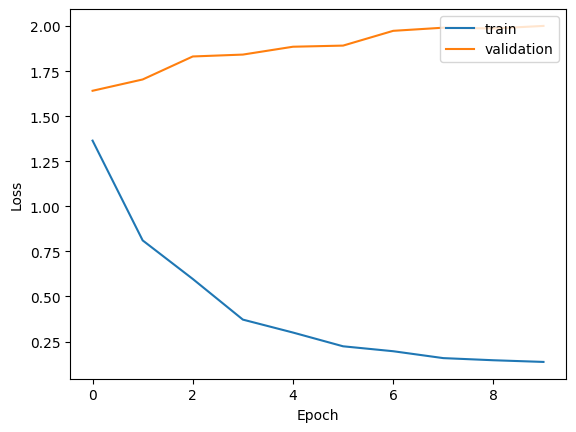

In [18]:
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('pca_based_sepconv_plantdoc_learning_curves.png')
plt.show()